In [6]:
%pip install seaborn joblib xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## 1. Load Datasets  

In [15]:
loan_df = pd.read_csv("data/Loan_Default.csv")
loan_ms = pd.read_csv("data/Loan.txt", sep='\t')
borrower_ms = pd.read_csv("data/Borrower.txt", sep='\t')

# Optionally merge Microsoft dataset tables if needed
microsoft_df = pd.merge(loan_ms, borrower_ms, how='left', on='memberId')

# Combine datasets (adjust to matching columns)
data = pd.concat([loan_df, microsoft_df], axis=0, ignore_index=True)
print("Combined dataset shape:", data.shape)


Combined dataset shape: (248670, 60)


## 2. Basic Dataset Overview  

In [16]:
print("\n--- FIRST 5 RECORDS ---")
print(data.head())

print("\n--- LAST 5 RECORDS ---")
print(data.tail())

print("\n--- SHAPE OF DATA (ROWS, COLUMNS) ---")
print(data.shape)

print("\n--- COLUMN NAMES ---")
print(list(data.columns))

print("\n--- DATA TYPES ---")
print(data.dtypes)

print("\n--- STATISTICAL SUMMARY ---")
print(data.describe(include='all'))

print("\n--- DATAFRAME INFO ---")
print(data.info())



--- FIRST 5 RECORDS ---
        ID    year loan_limit             Gender approv_in_adv loan_type  \
0  24890.0  2019.0         cf  Sex Not Available         nopre     type1   
1  24891.0  2019.0         cf               Male         nopre     type2   
2  24892.0  2019.0         cf               Male           pre     type1   
3  24893.0  2019.0         cf               Male         nopre     type1   
4  24894.0  2019.0         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   lengthCreditHistory  numTotalCreditLines  numOpenCreditLin

## 3. Handling Missing Values & Duplicates  

In [18]:
print("Missing values per column:")
print(data.isnull().sum())

print("Duplicate rows:", data.duplicated().sum())
data = data.drop_duplicates()

# Impute missing values
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)
print("Missing values handled.")


Missing values per column:
ID                           0
year                         0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Typ

## 4. Schema Definition & Data Type Conversion  

In [19]:
schema = {
    'loan_amount': 'float',
    'rate_of_interest': 'float',
    'term': 'category',
    'Credit_Score': 'float',
    'income': 'float',
    'loan_purpose': 'category',
    'Credit_Worthiness': 'category',
    'Gender': 'category',
    'Status': 'category',
    'age': 'float',
    'LTV': 'float',
    'dtir1': 'float'
}

for col, dtype in schema.items():
    if col in data.columns:
        try:
            if dtype == 'category':
                data[col] = data[col].astype('category')
            else:
                data[col] = pd.to_numeric(data[col], errors='coerce').astype(dtype)
        except Exception as e:
            print(f"⚠️ Could not convert {col}: {e}")
print("Schema conversion done.")


Schema conversion done.


## 5. Exploratory Data Visualization  

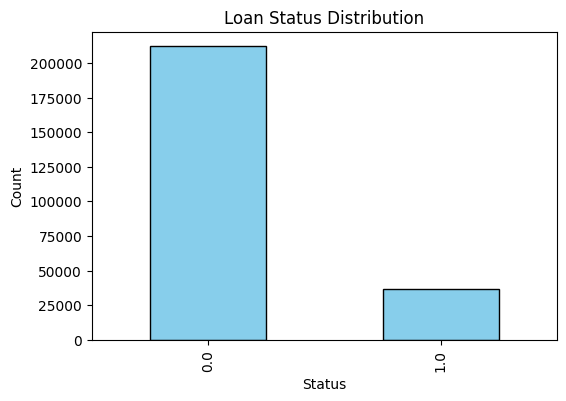

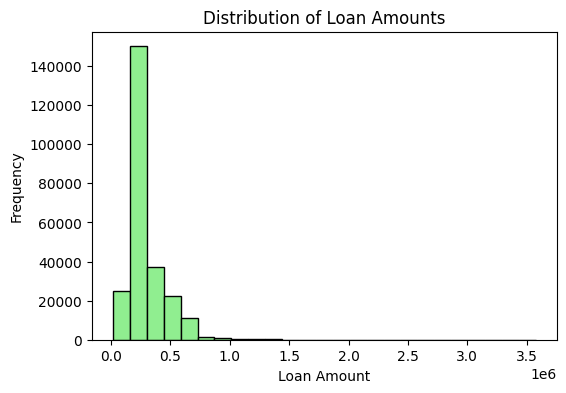

C:\Users\Purvi\AppData\Local\Temp\ipykernel_5036\578873277.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y='loan_amount', data=data, palette='Set2')


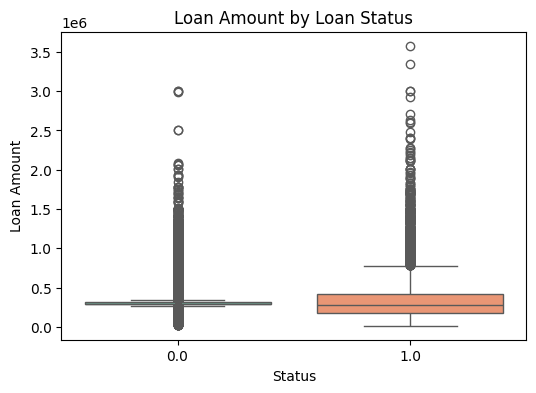

In [20]:
plt.figure(figsize=(6,4))
data['Status'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Loan Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data['loan_amount'].dropna(), bins=25, color='lightgreen', edgecolor='black')
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Status', y='loan_amount', data=data, palette='Set2')
plt.title('Loan Amount by Loan Status')
plt.xlabel('Status')
plt.ylabel('Loan Amount')
plt.show()


## 6. Train–Test Split & Feature Scaling  

In [50]:
target_column = 'Status'
X = loan_df.drop(columns=[target_column])
y = loan_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[cat_cols])

X_train_encoded = pd.DataFrame(encoder.transform(X_train[cat_cols]),
                               columns=encoder.get_feature_names_out(cat_cols),
                               index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[cat_cols]),
                              columns=encoder.get_feature_names_out(cat_cols),
                              index=X_test.index)

X_train_final = pd.concat([X_train[num_cols].reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test[num_cols].reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# 🧹 Clean feature names for XGBoost
X_train_final.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train_final.columns]
X_test_final.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test_final.columns]

# Ensure all names are strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

if list(X_train_final.columns) == list(X_test_final.columns):
    print("\n✅ Column consistency check passed! Columns match between train and test sets.")
else:
    print("\n⚠️ Column mismatch detected!")
    print("Missing in Test:", set(X_train_final.columns) - set(X_test_final.columns))
    print("Missing in Train:", set(X_test_final.columns) - set(X_train_final.columns))

scaler = StandardScaler()
X_train_final[num_cols] = scaler.fit_transform(X_train_final[num_cols])
X_test_final[num_cols] = scaler.transform(X_test_final[num_cols])

print("\n✅ StandardScaler applied to numerical features successfully!")
print("\nEncoded train shape:", X_train_final.shape)
print("Encoded test shape:", X_test_final.shape)

print("\n🔍 Before Encoding (sample):")
print(X.head(2))
print("\n🔍 After Encoding & Scaling (Train sample):")
print(X_train_final.head(2))

print("Before Scaling:\n", X_train[num_cols].head())
print("\nAfter Scaling (Train):\n", X_train_final[num_cols].head())


✅ Column consistency check passed! Columns match between train and test sets.

✅ StandardScaler applied to numerical features successfully!

Encoded train shape: (118936, 77)
Encoded test shape: (29734, 77)

🔍 Before Encoding (sample):
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   

   income  credit_type  Credit_Score  co-applicant_credit_type    age  \
0  1740.0          EXP           758                       CIB  25-34   
1  4980.0         EQUI           552                       EXP  55-64   

  submission_of_application        LTV Region  Security_Type dtir1  
0                   to_inst 

In [51]:
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [53]:
# --------------------------------
# 🔸 Step 6.6: Handle Any Remaining Missing Values
# --------------------------------
print("\nChecking for missing values after encoding & scaling...")

missing_train = X_train_final.isnull().sum().sum()
missing_test = X_test_final.isnull().sum().sum()

print(f"Missing values in training data: {missing_train}")
print(f"Missing values in testing data: {missing_test}")

# Replace any NaNs with 0 (safe for scaled and encoded data)
if missing_train > 0 or missing_test > 0:
    X_train_final = X_train_final.fillna(0)
    X_test_final = X_test_final.fillna(0)
    print("✅ All missing values replaced with 0.")

else:
    print("✅ No missing values found in training or testing data.")



Checking for missing values after encoding & scaling...
Missing values in training data: 0
Missing values in testing data: 0
✅ No missing values found in training or testing data.


## 7. Model Training & Evaluation (Multiple Models)  

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Empty list to store model results
model_results = []

# Helper function to calculate performance metrics
def get_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    else:
        specificity = np.nan

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None and len(np.unique(y_true)) == 2 else np.nan
    return accuracy, sensitivity, precision, specificity, f1, auc

Logistic Regression Model

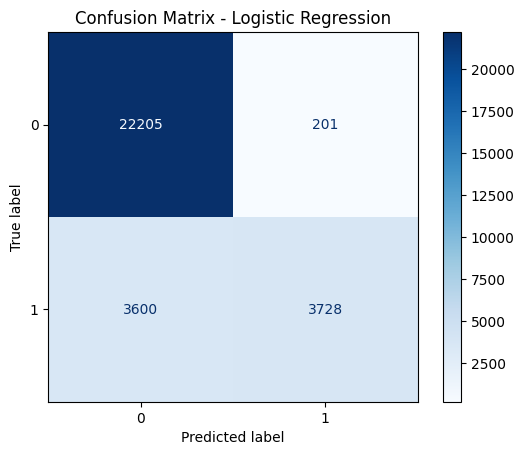

In [55]:
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_final, y_train)

y_pred = log_reg.predict(X_test_final)
y_proba = log_reg.predict_proba(X_test_final)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([1, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(log_reg, X_test_final, y_test, cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


Naive Bayes Model

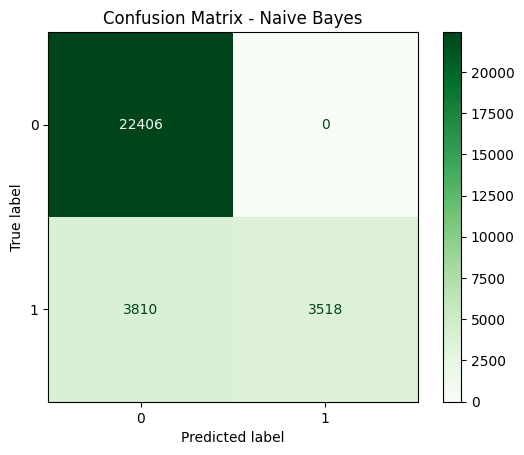

In [56]:
from sklearn.naive_bayes import GaussianNB

model_name = "Naive Bayes"
nb_model = GaussianNB()
nb_model.fit(X_train_final, y_train)

y_pred = nb_model.predict(X_test_final)
y_proba = nb_model.predict_proba(X_test_final)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([3, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(nb_model, X_test_final, y_test, cmap="Greens", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


Decision Tree

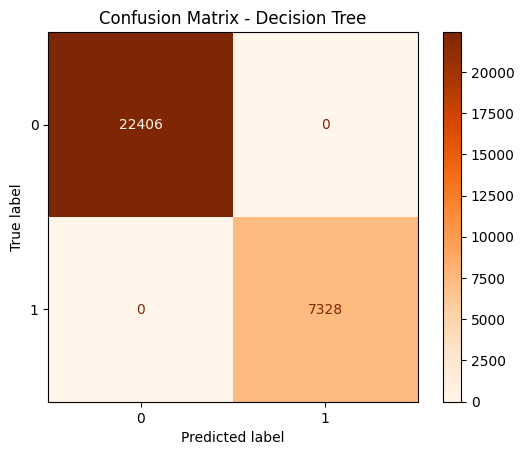

In [57]:
from sklearn.tree import DecisionTreeClassifier

model_name = "Decision Tree"
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_final, y_train)

y_pred = dt_model.predict(X_test_final)
y_proba = dt_model.predict_proba(X_test_final)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([4, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(dt_model, X_test_final, y_test, cmap="Oranges", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


Random Forest

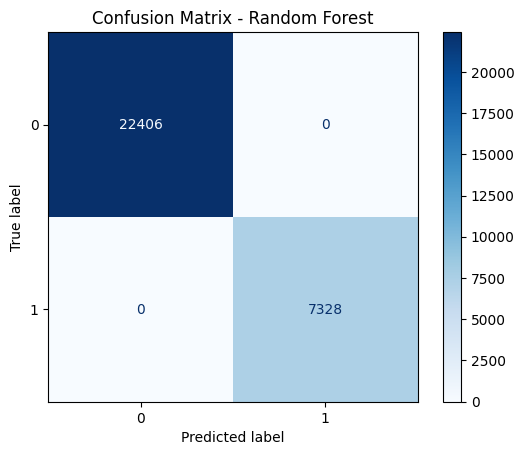

In [58]:
from sklearn.ensemble import RandomForestClassifier

model_name = "Random Forest"
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_final, y_train)

y_pred = rf_model.predict(X_test_final)
y_proba = rf_model.predict_proba(X_test_final)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([5, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(rf_model, X_test_final, y_test, cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


XGBoost

c:\Users\Purvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


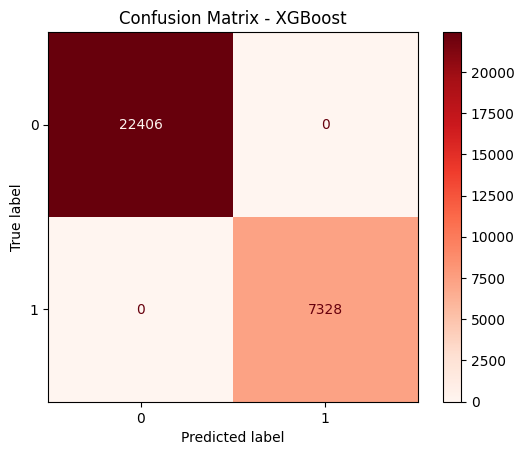

In [59]:
# --------------------------------
# 🔹 Model 6: XGBoost
# --------------------------------
from xgboost import XGBClassifier

model_name = "XGBoost"
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_final, y_train)

y_pred = xgb_model.predict(X_test_final)
y_proba = xgb_model.predict_proba(X_test_final  )[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([6, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_final, y_test, cmap="Reds", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


svm model

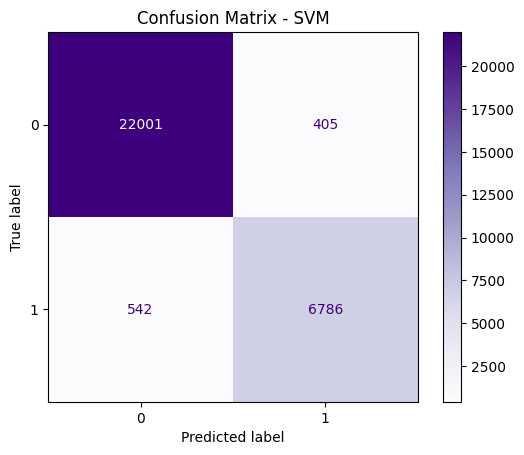

In [60]:
from sklearn.svm import SVC

model_name = "SVM"
svm_model = SVC(probability=True)
svm_model.fit(X_train_final, y_train)

y_pred = svm_model.predict(X_test_final)
y_proba = svm_model.predict_proba(X_test_final)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([2, model_name, acc, sens, prec, spec, f1, auc])

ConfusionMatrixDisplay.from_estimator(svm_model, X_test_final, y_test, cmap="Purples", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()


In [ ]:
columns = ["S.No", "Model", "Accuracy", "Sensitivity", "Precision", "Specificity", "F1-Score", "AUC"]
results_df = pd.DataFrame(model_results, columns=columns)

print("\n--- MODEL PERFORMANCE SUMMARY ---")
print(results_df)

# Save to CSV
results_df.to_csv("model_performance_summary.csv", index=False)


--- MODEL PERFORMANCE SUMMARY ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.872167     0.508734   0.948842     0.991029   
1     3          Naive Bayes  0.871864     0.480076   1.000000     1.000000   
2     4        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     5        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     6              XGBoost  1.000000     1.000000   1.000000     1.000000   
5     2                  SVM  0.968151     0.926037   0.943680     0.981924   

   F1-Score       AUC  
0  0.662343  0.847174  
1  0.648718  1.000000  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  1.000000  1.000000  
5  0.934775  0.995218  


C:\Users\Purvi\AppData\Local\Temp\ipykernel_5036\3750854076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")


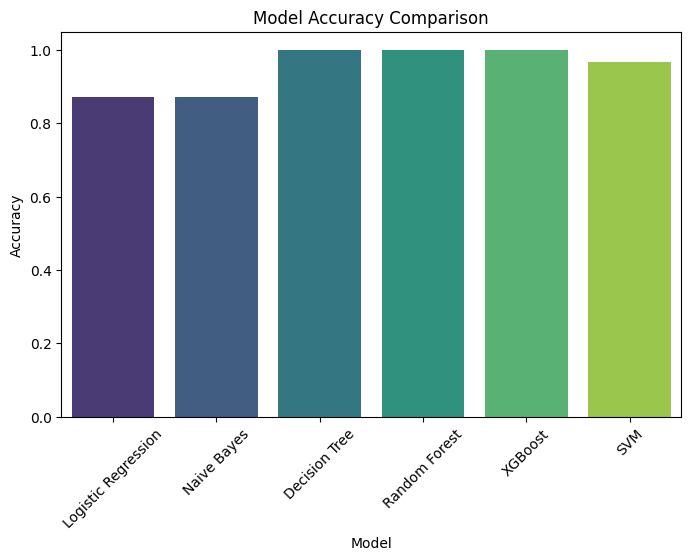

In [62]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [63]:
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"🏆 Best training model: {best_model['Model']} with Accuracy {best_model['Accuracy']:.4f}")

# Save model pipeline (example: Random Forest)
final_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
final_model.fit(X_train_final, y_train)
joblib.dump(final_model, "final_loan_default_model.joblib")
print("Model saved as final_loan_default_model.joblib")

🏆 Best training model: Decision Tree with Accuracy 1.0000
Model saved as final_loan_default_model.joblib


✅ Evaluated: Logistic Regression
✅ Evaluated: Naive Bayes
✅ Evaluated: Decision Tree
✅ Evaluated: Random Forest
✅ Evaluated: XGBoost
✅ Evaluated: Linear SVM 

--- TESTING PERFORMANCE SUMMARY ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.872167     0.508734   0.948842     0.991029   
1     2          Naive Bayes  0.871864     0.480076   1.000000     1.000000   
2     3        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     4        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     5              XGBoost  1.000000     1.000000   1.000000     1.000000   
5     6          Linear SVM   0.968151     0.926037   0.943680     0.981924   

   F1-Score       AUC  
0  0.662343  0.847174  
1  0.648718  1.000000  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  1.000000  1.000000  
5  0.934775  0.995218  

💾 Testing results saved as 'model_testing_summary.csv'


C:\Users\Purvi\AppData\Local\Temp\ipykernel_5036\2732977433.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=testing_df, x="Model", y="Accuracy", palette="coolwarm")


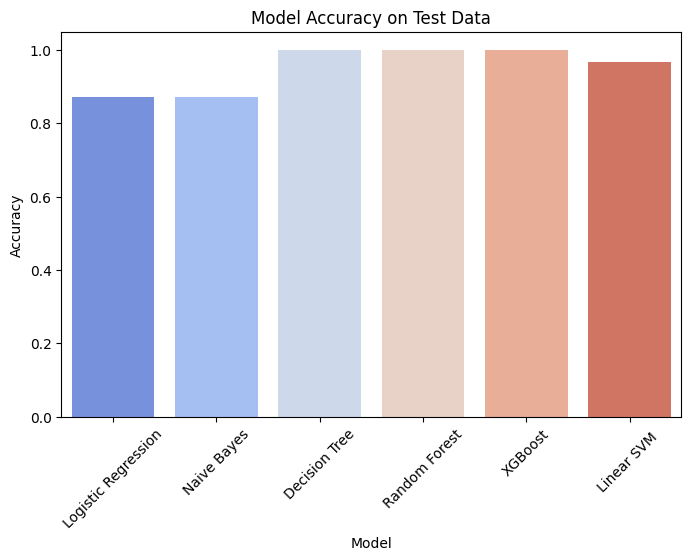

In [70]:
# --------------------------------
# 🔹 Step 10: Evaluate Models on Test Data (Testing Table)
# --------------------------------

# Reuse same helper function for metrics
def get_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    else:
        specificity = np.nan
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None and len(np.unique(y_true)) == 2 else np.nan
    return accuracy, sensitivity, precision, specificity, f1, auc

# Create a list to store testing results
testing_results = []

# Dictionary of trained models
trained_models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Linear SVM ": svm_model,   # replace with your final SVM variable name
}

# Evaluate each model on test data
for i, (name, model) in enumerate(trained_models.items(), start=1):
    try:
        y_pred = model.predict(X_test_final)
        # Handle probability output if model supports it
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_final)[:, 1]
        else:
            y_proba = None

        acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
        testing_results.append([i, name, acc, sens, prec, spec, f1, auc])
        print(f"✅ Evaluated: {name}")
    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")

# Create a DataFrame for testing results
testing_df = pd.DataFrame(
    testing_results,
    columns=["S.No", "Model", "Accuracy", "Sensitivity", "Precision", "Specificity", "F1-Score", "AUC"]
)

print("\n--- TESTING PERFORMANCE SUMMARY ---")
print(testing_df)

# Save to CSV for record
testing_df.to_csv("model_testing_summary.csv", index=False)
print("\n💾 Testing results saved as 'model_testing_summary.csv'")

# Optional: visualize test accuracies
plt.figure(figsize=(8, 5))
sns.barplot(data=testing_df, x="Model", y="Accuracy", palette="coolwarm")
plt.title("Model Accuracy on Test Data")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()


In [71]:
# Merge both tables on Model name
final_comparison = pd.merge(
    results_df,
    testing_df,
    on="Model",
    suffixes=("_Train", "_Test")
)

# Reorder columns neatly
cols = [
    "S.No_Train", "Model",
    "Accuracy_Train", "Accuracy_Test",
    "F1-Score_Train", "F1-Score_Test",
    "AUC_Train", "AUC_Test",
    "Sensitivity_Train", "Sensitivity_Test",
    "Specificity_Train", "Specificity_Test",
    "Precision_Train", "Precision_Test"
]
final_comparison = final_comparison[cols]

print("\n--- FINAL COMBINED TRAINING & TESTING PERFORMANCE ---")
print(final_comparison)

# Save to CSV
final_comparison.to_csv("final_model_comparison.csv", index=False)
print("\n💾 Combined performance table saved as 'final_model_comparison.csv'")



--- FINAL COMBINED TRAINING & TESTING PERFORMANCE ---
   S.No_Train                Model  Accuracy_Train  Accuracy_Test  \
0           1  Logistic Regression        0.872167       0.872167   
1           3          Naive Bayes        0.871864       0.871864   
2           4        Decision Tree        1.000000       1.000000   
3           5        Random Forest        1.000000       1.000000   
4           6              XGBoost        1.000000       1.000000   

   F1-Score_Train  F1-Score_Test  AUC_Train  AUC_Test  Sensitivity_Train  \
0        0.662343       0.662343   0.847174  0.847174           0.508734   
1        0.648718       0.648718   1.000000  1.000000           0.480076   
2        1.000000       1.000000   1.000000  1.000000           1.000000   
3        1.000000       1.000000   1.000000  1.000000           1.000000   
4        1.000000       1.000000   1.000000  1.000000           1.000000   

   Sensitivity_Test  Specificity_Train  Specificity_Test  Precision_Train

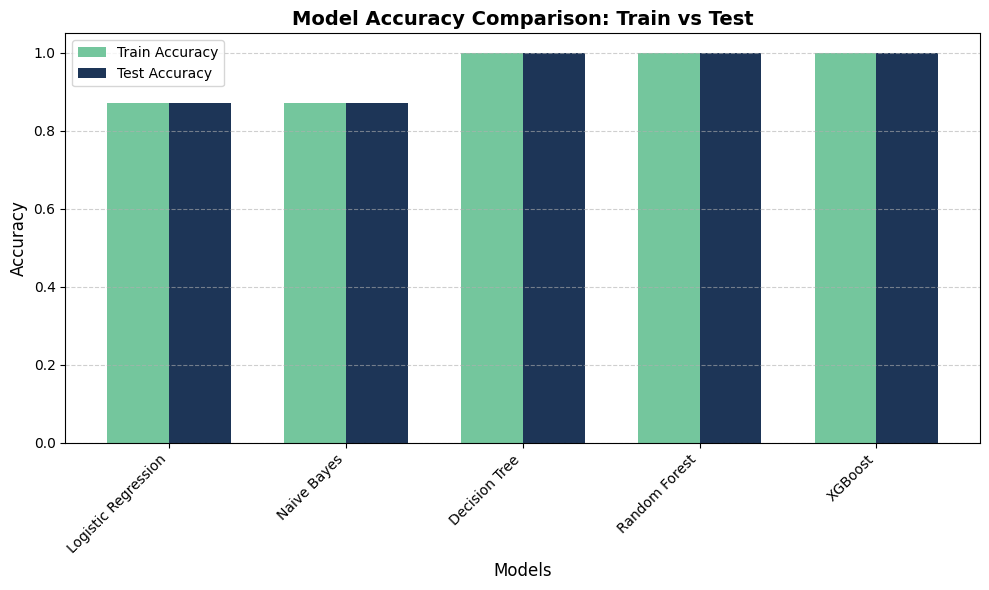

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------------
# ✅ Train vs Test Accuracy Comparison Plot
# ---------------------------------------

plt.figure(figsize=(10, 6))

# Calculate bar width and x locations
x = np.arange(len(final_comparison["Model"]))
width = 0.35

plt.bar(x - width/2, final_comparison["Accuracy_Train"], width, label='Train Accuracy', color='#74c69d')
plt.bar(x + width/2, final_comparison["Accuracy_Test"], width, label='Test Accuracy', color='#1d3557')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison: Train vs Test", fontsize=14, fontweight='bold')
plt.xticks(x, final_comparison["Model"], rotation=45, ha='right')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
